- Use data to produce actionable outcomes
- Objective
  - Classify 5 different kind of dogs, Bulldog, Siberian Husky, Poodle, Goldren
    retriever, and German Shepeherd. The user should *act* upon this generated data
    only in sense of playiny &/ select a dog, but nothing more serious than that.
- Predictive models
  - Predict type of dog based on image provided by user.
- Gather data
  - **This would be the most diffcult part of your application.**
- Build application

# Gather data

We will use `icrawler` to download images from google image search. We will download
iamges by searching for the dog types that we want to detect.

All the data will be labeled by their parent folder. 

Remember, the world is full of biased datas. All the data that we will collect using
this mechanism will only be dogs that are artistically good looking and carefully
photographed.

Similarly, if we want to make a healthy skin detector, we would found all kind of
images of a beautiful star touching face, rather than healthy skin.

**Think carefully about type of datas that will exists.**

In [1]:
from pathlib import Path
from fastai.vision import *
from fastbook import *

dog_types = [
    "bulldog",
    "siberian husky",
    "poodle",
    "german shepherd",
    "golden retriever",
]

data_path = Path("data")


def crawl():
    from icrawler.builtin import GoogleImageCrawler

    for dog_type in dog_types:
        GoogleImageCrawler(storage={"root_dir": str(data_path / dog_type)}).crawl(
            keyword=dog_type,
            max_num=100,
        )
crawl()

/usr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
fns = get_image_files(data_path) # Notice it return a L, which is collection type of fast.ai
failed = verify_images(fns) # Verify the images
failed.map(Path.unlink) # Delete the failed images

(#0) []

Data loaders are important for fastai. We will use `DataLoaders` to store `DataLoader`
object. We will use one of a factory method, `DataBlock`, to create appropriate `DataLoader`

In [9]:
dogs = DataBlock(
    blocks=(
        ImageBlock,
        CategoryBlock,
    ),  # Independent variable: Image, Dependent variable: Category
    get_items=get_image_files,  # Function to get a list of datas. get_image_files accept a path and return a L of Path(image)
    splitter=RandomSplitter(
        valid_pct=0.2, seed=42
    ),  # randomly split the data into training and validation
    get_y=parent_label,  # Function to get the dependent variable, category. parent_label that use parent directory name as category
    item_tfms=RandomResizedCrop(224, min_scale=0.3),  # Since model are feeded with multiple images as mini-batch and grouped wiht tensor, we need to resize the image to the same size
)
dls = dogs.dataloaders(data_path) # With DataBlock object, one can create dataloaders.

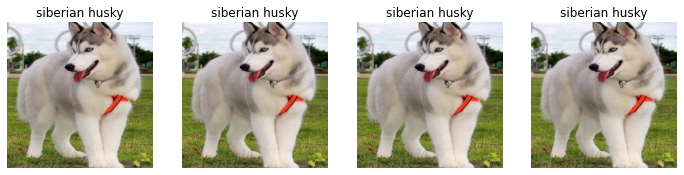

In [11]:
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

Creating random variations of the input data, such that they appear different but does
not change the meaning of the data, e.g., random rotate, crop, flipping, perspective
warping, adjust brightness, etc.

`aug_transforms` is a list of transforms that will be applied to the data for those
images.

Since all the data are now the same size, use `gpu` would work and save a lot of time.
Use `batch_tfms` to tell `fastai` to do so.

In [18]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms(mult=2),
)
dls = dogs.dataloaders(data_path)

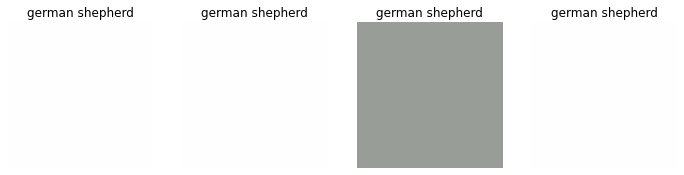

In [19]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)


RuntimeError: Exception occured in `TrainEvalCallback` when calling event `before_fit`:
	CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 1.96 GiB total capacity; 1.09 GiB already allocated; 2.94 MiB free; 1.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF